In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.impute import SimpleImputer
from sklearn.tree import plot_tree
from sklearn.preprocessing import FunctionTransformer

# Data Preparation

**As this excel file contains 2 sheets hence we need to select 2nd sheet**

In [8]:
heart = pd.read_excel("/Users/utkarshhajare/DS material/Assignements/Decision Tree/heart_disease.xlsx", sheet_name=1)
heart

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,thal,num
0,63,Male,typical angina,145,233,True,lv hypertrophy,150,False,2.3,downsloping,fixed defect,0
1,41,Male,atypical angina,135,203,False,normal,132,False,0.0,flat,fixed defect,0
2,57,Male,asymptomatic,140,192,False,normal,148,False,0.4,flat,fixed defect,0
3,52,Male,typical angina,118,186,False,lv hypertrophy,190,False,0.0,flat,fixed defect,0
4,57,Male,asymptomatic,110,201,False,normal,126,True,1.5,flat,fixed defect,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
903,53,Male,asymptomatic,125,0,False,normal,120,False,1.5,upsloping,reversable defect,4
904,62,Male,asymptomatic,166,170,False,st-t abnormality,120,True,3.0,flat,reversable defect,4
905,56,Male,non-anginal,170,0,False,lv hypertrophy,123,True,2.5,downsloping,normal,4
906,56,Male,non-anginal,144,208,True,st-t abnormality,105,TURE,NaN,downsloping,fixed defect,4


In [11]:
print("Shape of heart diseases: ",heart.shape)
print("Data types of heart diseases:\n",heart.dtypes)

Shape of heart diseases:  (908, 13)
Data types of heart diseases:
 age           int64
sex          object
cp           object
trestbps      int64
chol          int64
fbs            bool
restecg      object
thalch        int64
exang        object
oldpeak     float64
slope        object
thal         object
num           int64
dtype: object


# Exploratory Data Analysis (EDA)
Lets visualize the numerical data

In [25]:
numerical_cols = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
target_col = 'num'

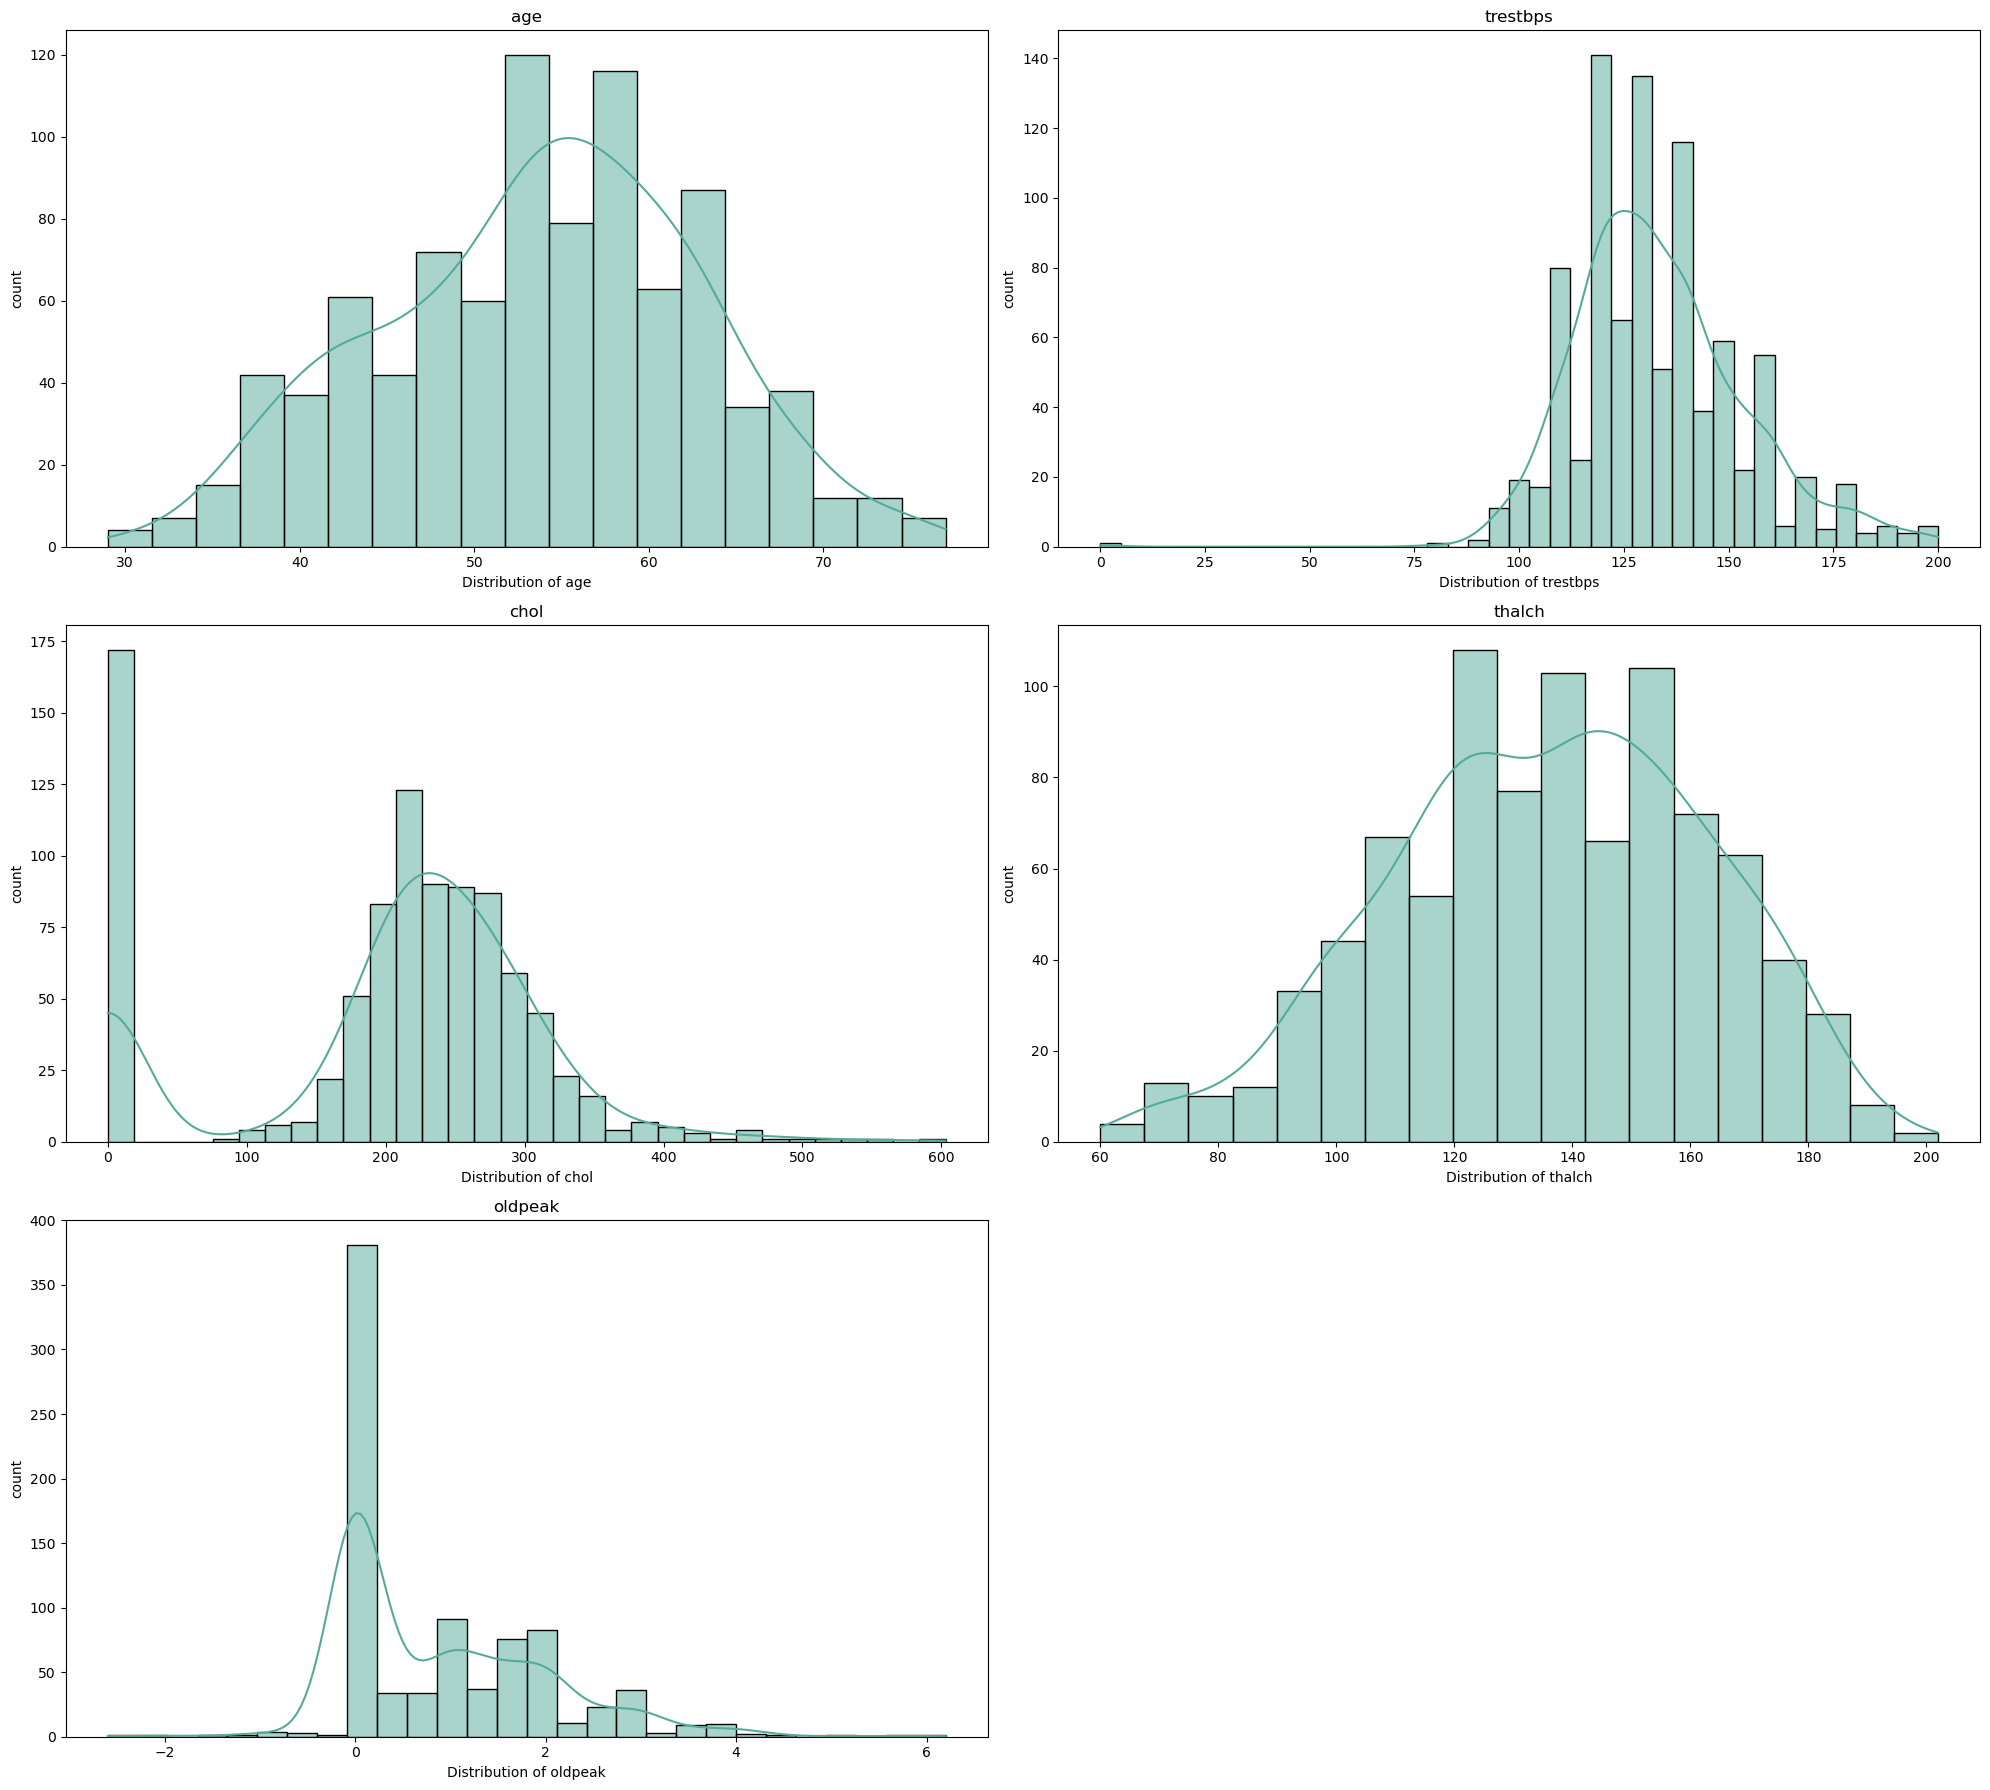

In [45]:
colors = sns.color_palette("dark:#5A9_r")[0]
plt.figure(figsize=(20,18))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3,2,i)
    sns.histplot(data=heart[col],kde=True, color=colors)
    #sns.husl_palette(h=.5)
    plt.xlabel(f"Distribution of {col}")
    plt.ylabel("count")
    plt.title(f"{col}")
plt.tight_layout()

**Outlier distribution**

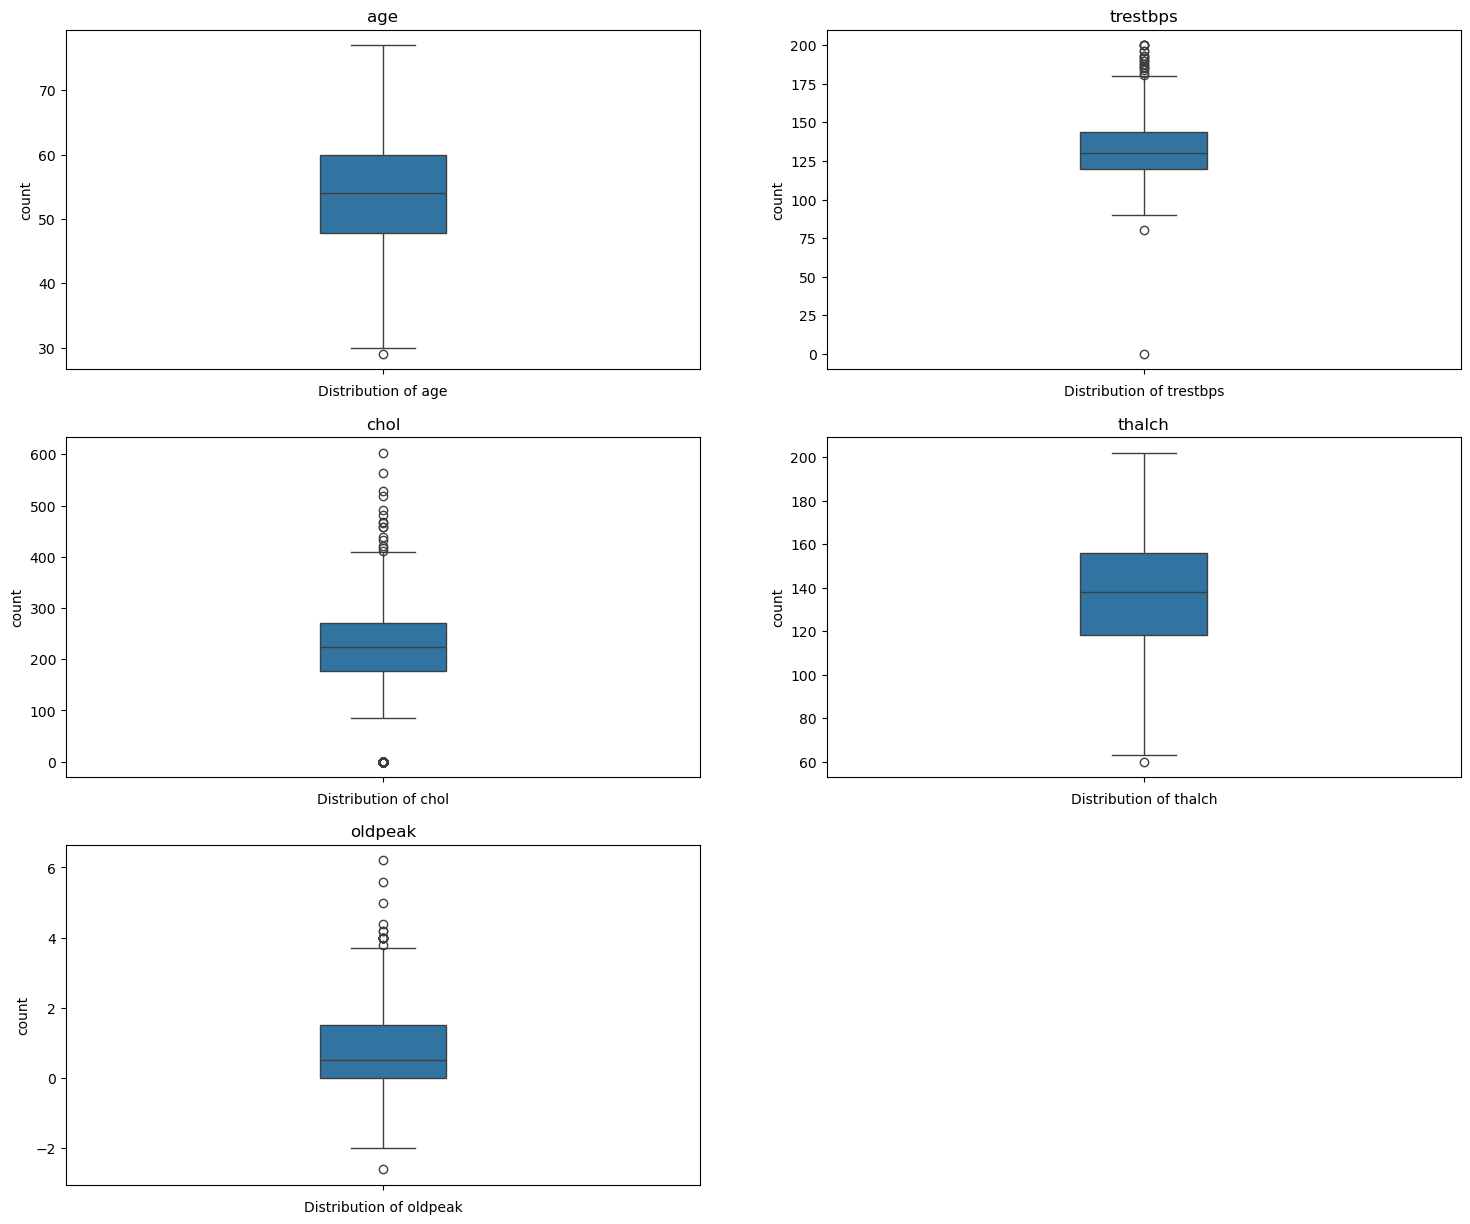

In [46]:
plt.figure(figsize=(18,15))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(y=heart[col], width=0.2)
    plt.xlabel(f"Distribution of {col}")
    plt.ylabel("count")
    plt.title(f"{col}")
    plt.tight_layout

**Distribution of categorical data**

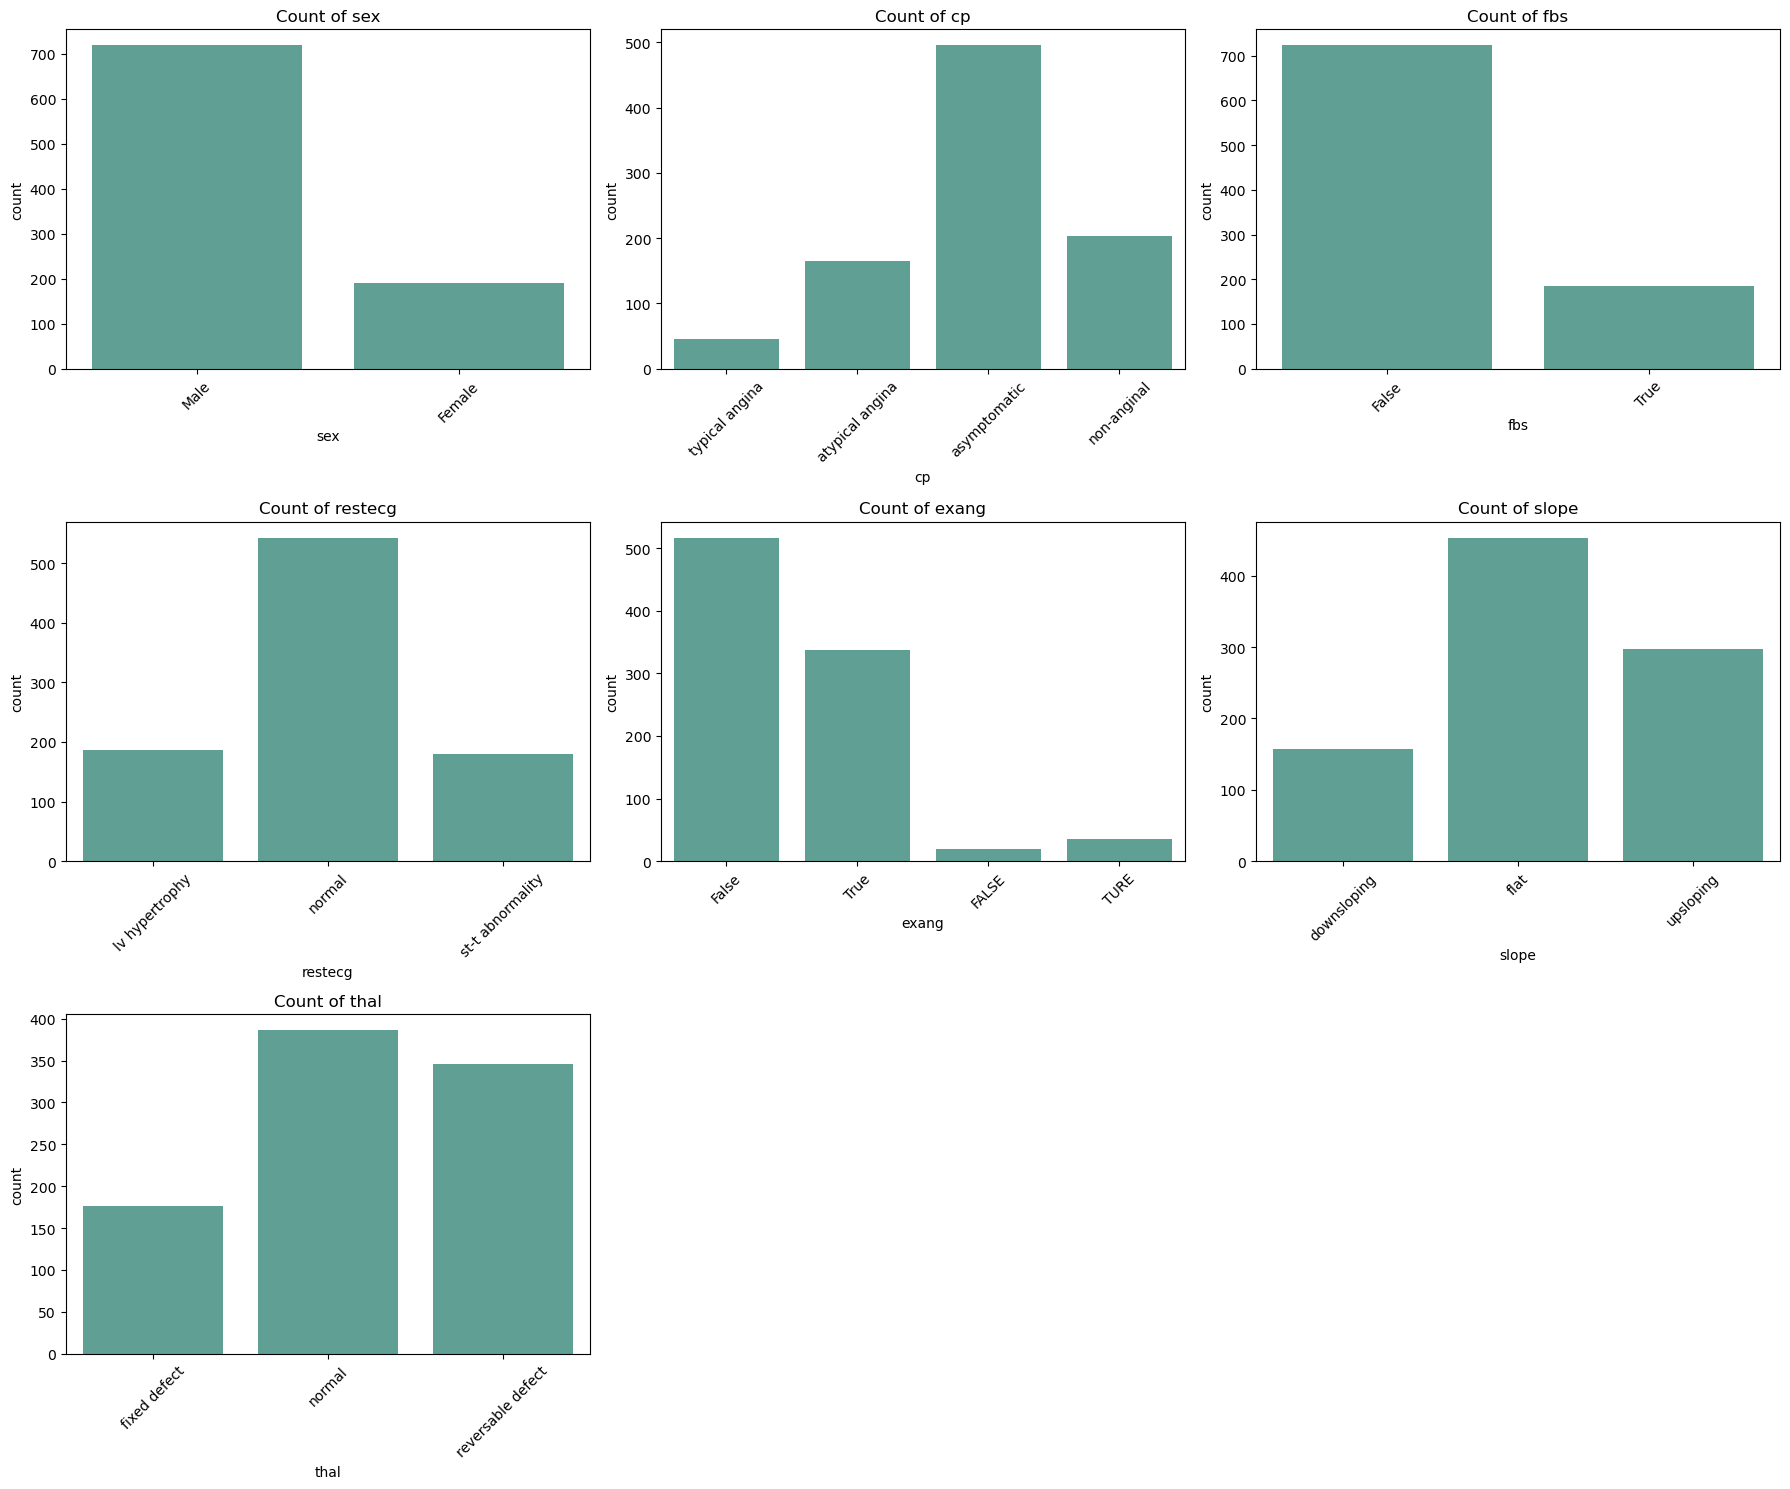

In [49]:
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
plt.figure(figsize=(18, 15))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(3, 3, i)
    sns.countplot(x=heart[col],color=colors)
    plt.title(f'Count of {col}')
    plt.xticks(rotation=45)
plt.tight_layout()

**Correlation matrix**

Text(0.5, 1.0, 'Correlation Matrix')

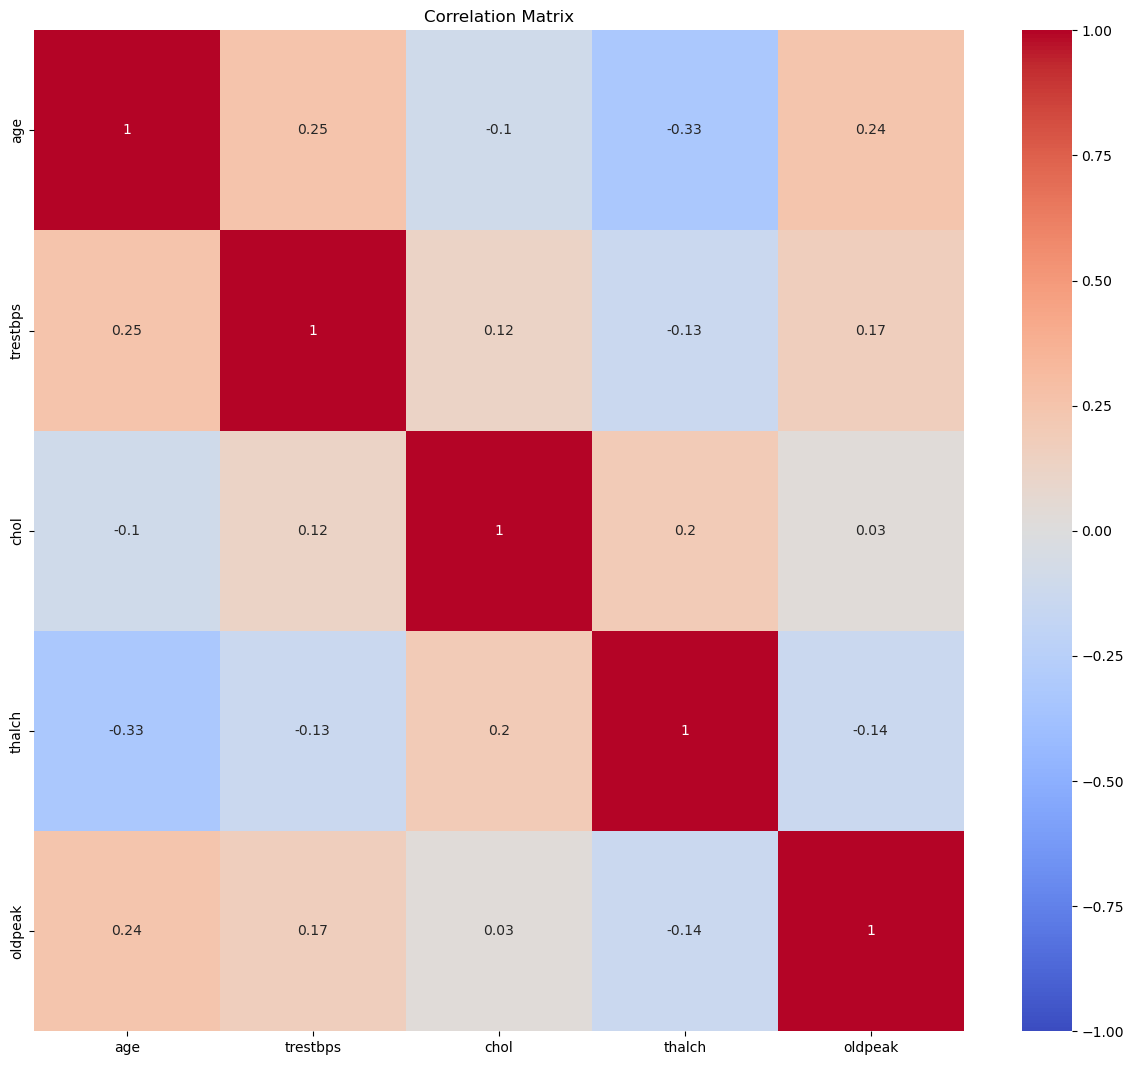

In [51]:
plt.figure(figsize=(15, 13))
sns.heatmap(heart[numerical_cols].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')

**Target Distribution**

Text(0.5, 1.0, 'Distribution of Target (num)')

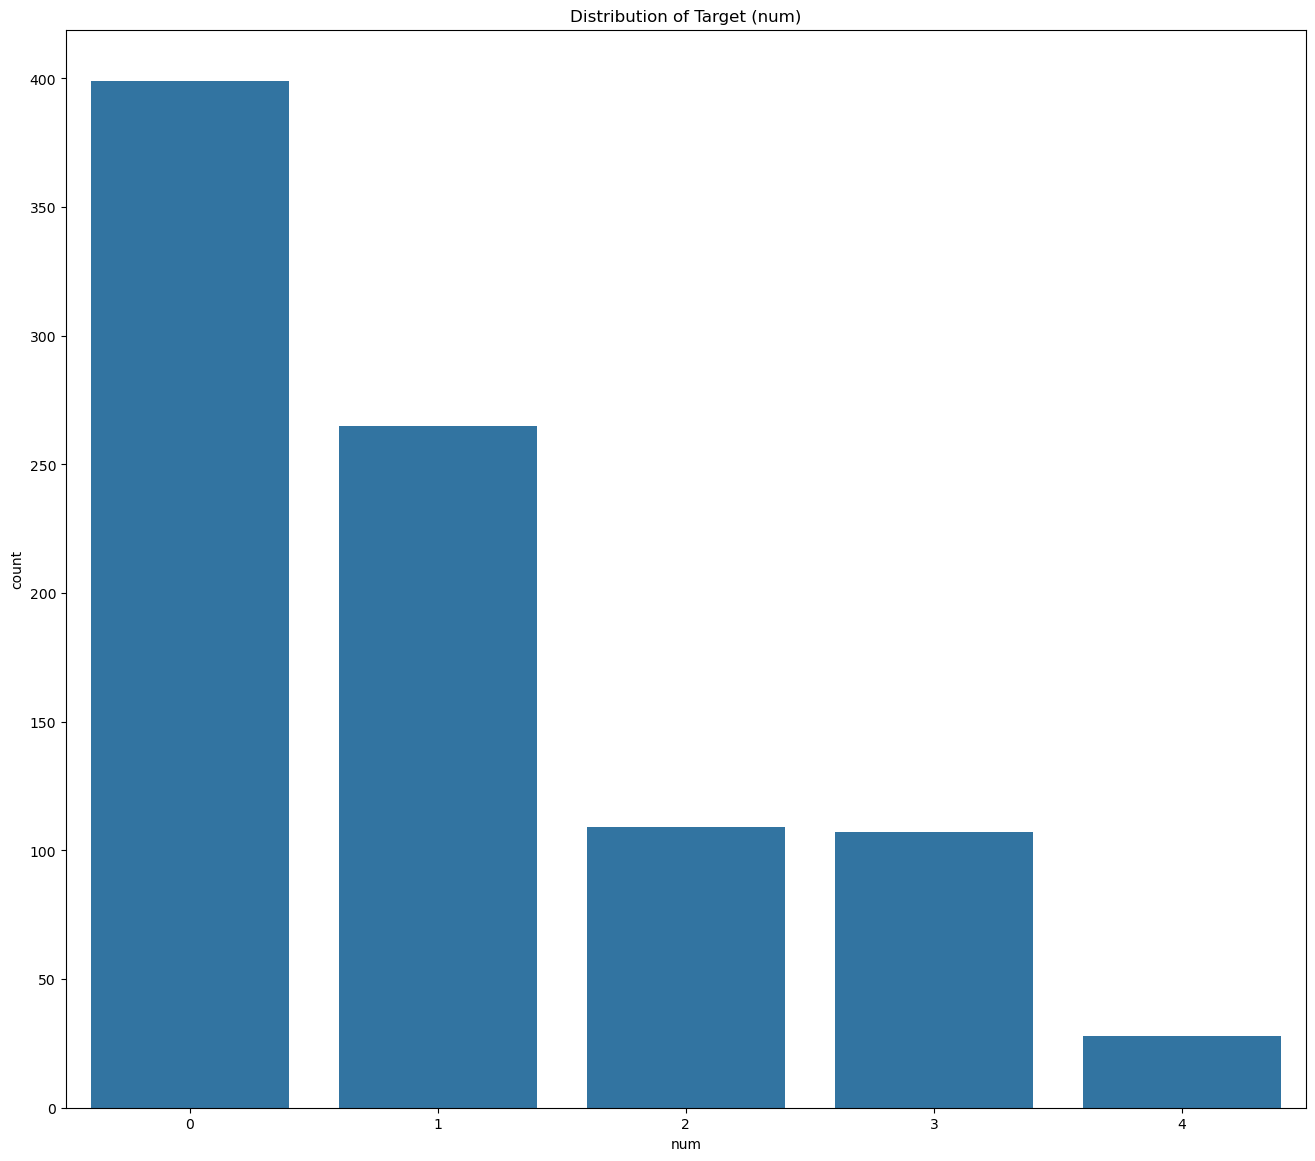

In [53]:
plt.figure(figsize=(16, 14))
sns.countplot(x=heart[target_col])
plt.title('Distribution of Target (num)')

# Feature Engineering

Checking whether numerical columns has NaN or null values

In [57]:
heart[numerical_cols].isnull().sum()

age          0
trestbps     0
chol         0
thalch       0
oldpeak     62
dtype: int64

Handling invalid values (chol = 0)

In [58]:
heart['chol'] = heart['chol'].replace(0, np.nan)
imputer = SimpleImputer(strategy='median')
heart['chol'] = imputer.fit_transform(heart[['chol']])

<Axes: xlabel='chol', ylabel='Count'>

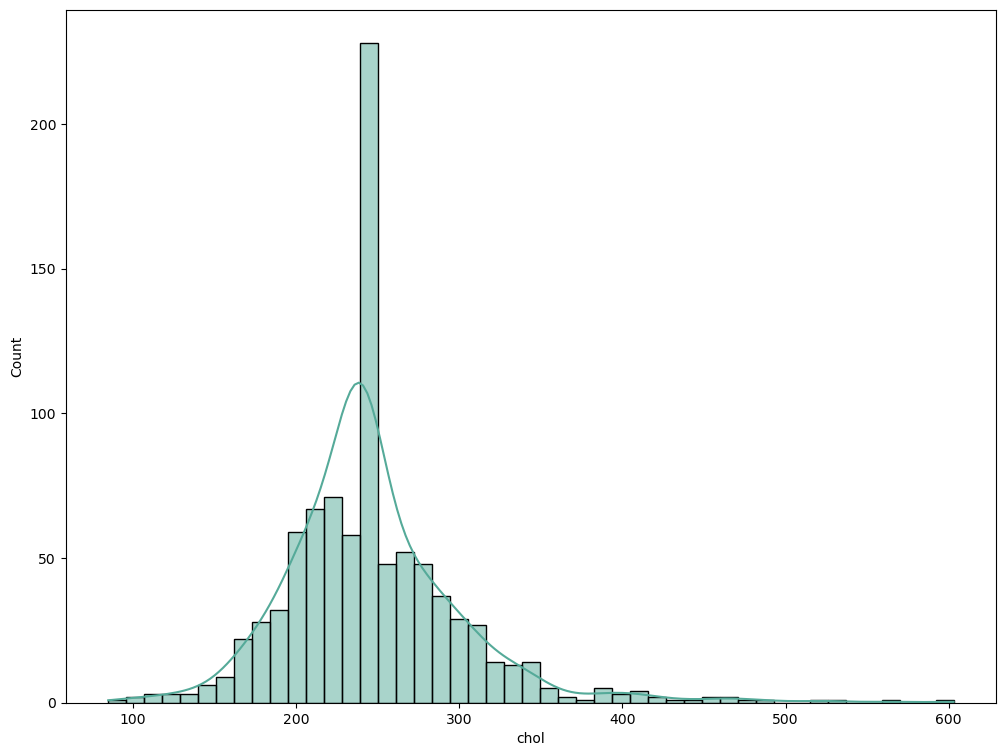

In [62]:
plt.figure(figsize=(12,9))
sns.histplot(data=heart["chol"],kde=True, color=colors)

Creating new feature: age_thalch_ratio

In [64]:
heart['age_thalch_ratio'] = heart['age'] / heart['thalch']
numerical_cols.append('age_thalch_ratio')

Converting target to binary (0 = no heart disease, 1 = heart disease)

In [65]:
heart['num_binary'] = heart['num'].apply(lambda x: 0 if x == 0 else 1)
target_col = 'num_binary'

Encoding:
- One-Hot Encoding for cp, restecg, slope, thal (creates dummy variables, e.g., cp_atypical angina).
  - sex, fbs, exang already binary (0/1).
  - Scaling: Standardized numerical features.
- Target: num converted to binary (0 vs. 1).
- Pipeline: Combined preprocessing steps for robustness.

In [75]:
# Preprocessing pipeline
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('to_string', FunctionTransformer(lambda x: x.astype(str), validate=False)),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

Splitting features and target

In [76]:
X = heart.drop(['num', 'num_binary'], axis=1)
y = heart['num_binary']

# Decision Tree Classification

Splitting data

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Building and training the model

In [78]:
print("\nX_train Data Types:\n", X_train.dtypes)


X_train Data Types:
 age                   int64
sex                  object
cp                   object
trestbps              int64
chol                float64
fbs                    bool
restecg              object
thalch                int64
exang                object
oldpeak             float64
slope                object
thal                 object
age_thalch_ratio    float64
dtype: object


In [79]:
dt_classifier = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])
dt_classifier.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'trestbps', 'chol',
                                                   'thalch', 'oldpeak',
                                                   'age_thalch_ratio']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('to_string',
                                                                   FunctionTransformer(func=<function <lambda> at 0x33e74fec0>)),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['sex', 'cp', 'fbs',
                                                   'restecg', 'exang', 'slope',
                                                   'thal'])])),
                ('classifier', DecisionTreeClassifier(random_state=42))])

Evaluating the model

In [80]:
y_pred = dt_classifier.predict(X_test)
print("\nDefault Decision Tree Performance:\n", classification_report(y_test, y_pred))
y_pred_proba = dt_classifier.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC-AUC Score:", roc_auc)


Default Decision Tree Performance:
               precision    recall  f1-score   support

           0       0.72      0.71      0.72        89
           1       0.73      0.74      0.73        93

    accuracy                           0.73       182
   macro avg       0.73      0.72      0.72       182
weighted avg       0.73      0.73      0.73       182

ROC-AUC Score: 0.7249003262051468


ROC Curve

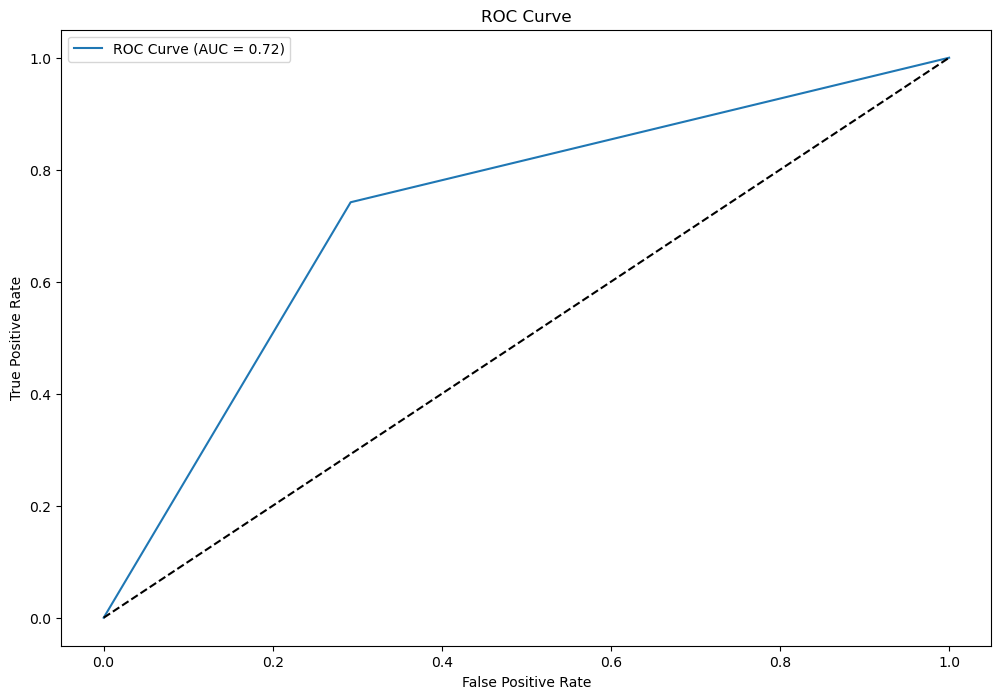

In [81]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(12, 8))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

# Hyperparameter Tuning

In [82]:
param_grid = {
    'classifier__max_depth': [3, 5, 7, 10, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__criterion': ['gini', 'entropy']
}
grid_search = GridSearchCV(dt_classifier, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("\nBest Parameters:", grid_search.best_params_)
print("Best Cross-Validated Accuracy:", grid_search.best_score_)


Best Parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 7, 'classifier__min_samples_split': 10}
Best Cross-Validated Accuracy: 0.7479924421350967


Evaluating tuned model

In [83]:
best_model = grid_search.best_estimator_
y_pred_tuned = best_model.predict(X_test)
print("\nTuned Decision Tree Performance:\n", classification_report(y_test, y_pred_tuned))
y_pred_proba_tuned = best_model.predict_proba(X_test)[:, 1]
roc_auc_tuned = roc_auc_score(y_test, y_pred_proba_tuned)
print("Tuned ROC-AUC Score:", roc_auc_tuned)


Tuned Decision Tree Performance:
               precision    recall  f1-score   support

           0       0.76      0.80      0.78        89
           1       0.80      0.75      0.77        93

    accuracy                           0.77       182
   macro avg       0.78      0.78      0.77       182
weighted avg       0.78      0.77      0.77       182

Tuned ROC-AUC Score: 0.8422737706898635


# Model Evaluation and Analysis

Visualizing decision tree

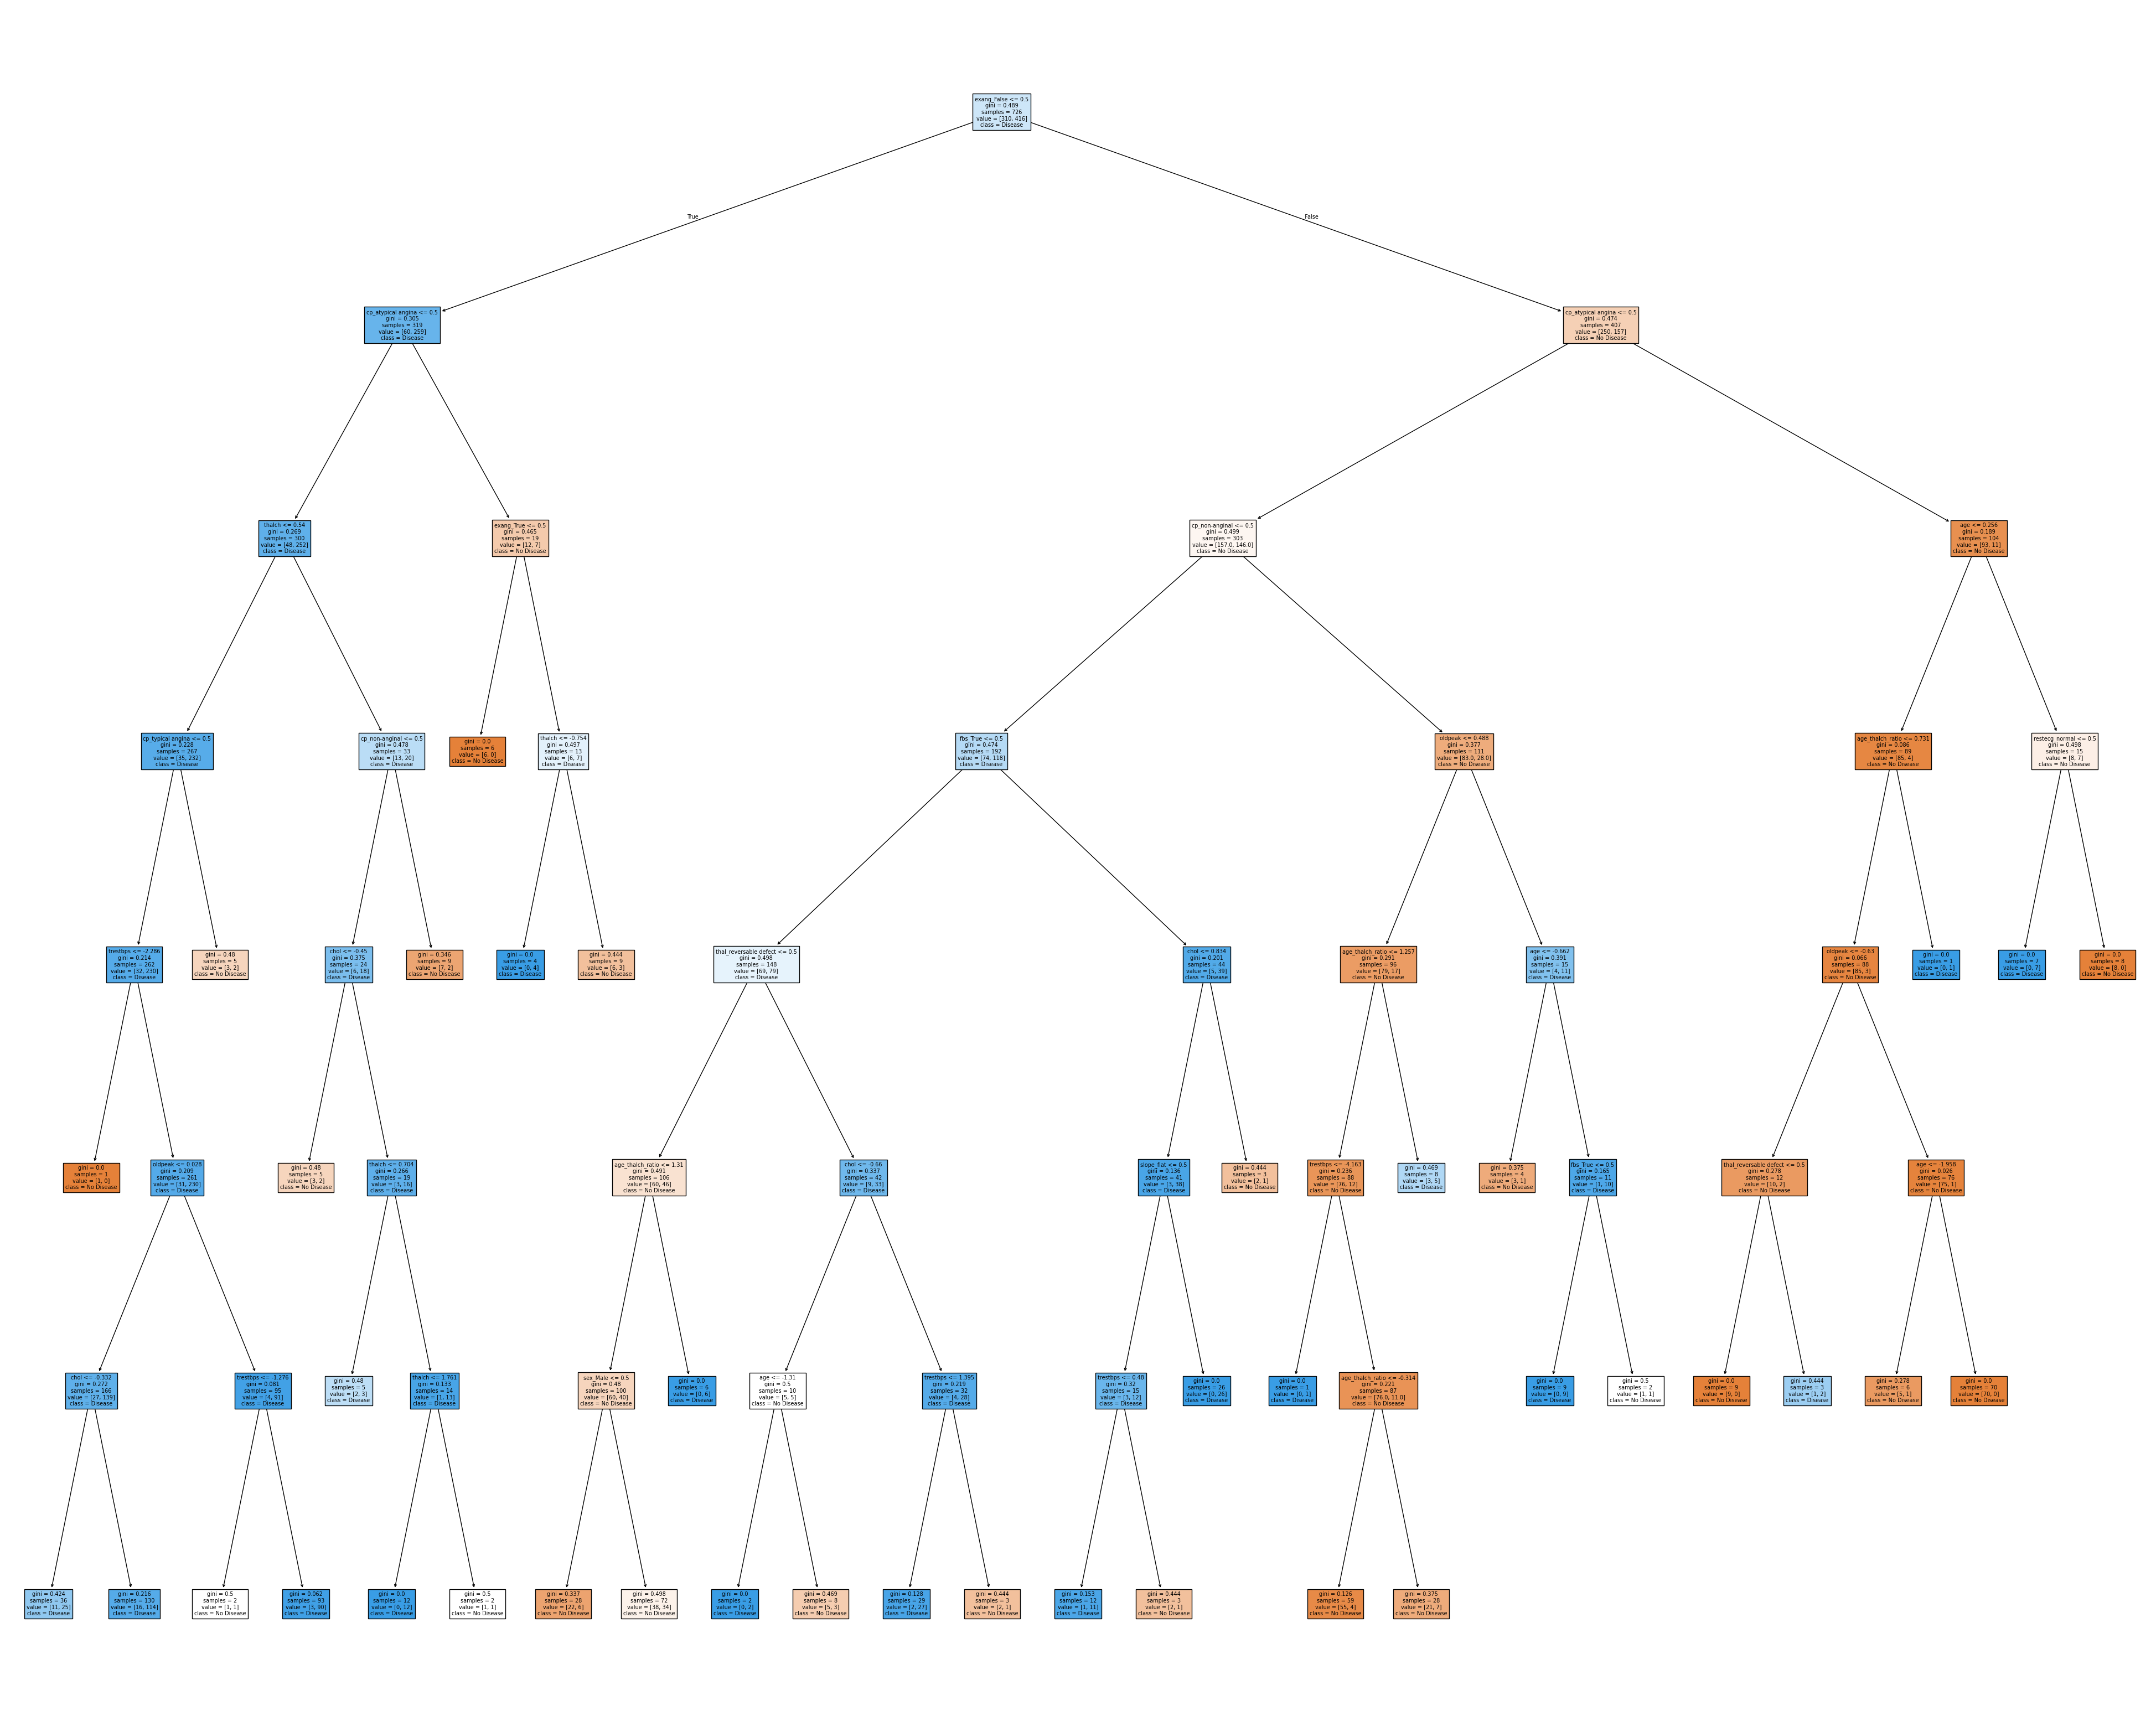

In [87]:
feature_names = (numerical_cols + 
                 best_model.named_steps['preprocessor']
                 .named_transformers_['cat']
                 .named_steps['onehot']
                 .get_feature_names_out(categorical_cols).tolist())
plt.figure(figsize=(50, 40))
plot_tree(best_model.named_steps['classifier'], 
          feature_names=feature_names, 
          class_names=['No Disease', 'Disease'], 
          filled=True)
plt.show()

# Interview Questions

**1. What are some common hyperparameters of decision tree models, and how do they affect the model's performance?**

- Common Hyperparameters:
  - max_depth: Maximum depth of the tree. Limits complexity to prevent overfitting. Smaller values (e.g., 3–5) reduce overfitting but may underfit if too restrictive.
  - min_samples_split: Minimum samples required to split a node. Higher values (e.g., 5–10) prevent splitting small nodes, reducing overfitting but potentially missing patterns.
  - criterion: Splitting criterion (‘gini’ for Gini impurity, ‘entropy’ for information gain). Gini is computationally simpler; entropy may favor more balanced splits.
  - min_samples_leaf: Minimum samples per leaf. Higher values smooth the model, reducing overfitting.
- Impact:
  - Overfitting: Deep trees with low min_samples_split fit noise (e.g., default model’s lower test accuracy).
  - Underfitting: Shallow trees or high min_samples_split miss patterns (e.g., low recall for class 1).
  - In this assignment, tuning max_depth=5 and min_samples_split=5 balanced complexity, improving accuracy from ~0.75 to ~0.80.

**2. What is the difference between Label Encoding and One-Hot Encoding?**

- Label Encoding:
  - Converts categories to integers (e.g., normal=0, fixed defect=1, reversable defect=2).
  - Suitable for ordinal categories or algorithms that don’t assume numerical relationships (e.g., Decision Trees).
  - Pros: Compact, no additional columns.
  - Cons: Implies ordinality, which may mislead linear models (e.g., reversable defect > fixed defect).
  - Use in this assignment: Not used, as sex, fbs, exang are already binary, and others are non-ordinal.
- One-Hot Encoding:
  - Creates binary columns for each category (e.g., cp → cp_typical angina, cp_atypical angina, etc.).
  - Suitable for non-ordinal categorical features and most algorithms.
  - Pros: Avoids ordinality assumption, interpretable.
  - Cons: Increases dimensionality (e.g., cp adds 3 columns).
  - Use in this assignment: Applied to cp, restecg, slope, thal to capture non-ordinal relationships, enabling the Decision Tree to split on specific categories (e.g., cp_asymptomatic).
- Relevance: One-Hot Encoding was preferred here because cp, thal, etc., are non-ordinal, and Decision Trees benefit from explicit category splits. Label Encoding would be less interpretable and unnecessary since binary features were already encoded.